In [25]:
from __future__ import print_function
from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
import numpy as np
from six.moves import range
import keras.backend as K
from sklearn.metrics import accuracy_score

In [2]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, chars, maxlen):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.chars)))
        for i, c in enumerate(C):
            X[i, self.char_indices[c]] = 1
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)

In [3]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [4]:
# Parameters for the model and dataset
TRAINING_SIZE = 5000
DIGITS = 2
OPS = 2
INVERT = True
# Try replacing GRU, or SimpleRNN
RNN = recurrent.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1
MAXLEN = OPS * DIGITS + OPS - 1

In [5]:
chars = '0123456789+ '
ctable = CharacterTable(chars, MAXLEN)

In [6]:
def generate_data(training_size, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    questions = []
    expected = []
    seen = set()
    print('Generating data... ')
    while len(questions) < training_size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, num_digits + 1))))

        ops = []
        for i in range(num_ops):
            ops.append(f())
        # Skip any addition questions we've already seen
        # Also skip any such that X+Y == Y+X (hence the sorting)
        ops.sort()
        key = tuple(ops)
        if key in seen:
            continue
        seen.add(key)
        # Pad the data with spaces such that it is always MAXLEN
        q = '+'.join([str(op) for op in ops])
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(sum(ops))
        # Answers can be of maximum size DIGITS + 1
        ans += ' ' * (num_digits + 1 - len(ans))
        if INVERT:
            query = query[::-1]
        questions.append(query)
        expected.append(ans)
    print('Total addition questions:', len(questions))
    
    return questions, expected

In [7]:
def create_train_valid(questions, expected, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    print('Vectorization...')
    X = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
    y = np.zeros((len(questions), num_digits + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        X[i] = ctable.encode(sentence, maxlen=MAXLEN)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, maxlen=num_digits + 1)

    # Shuffle (X, y) in unison as the later parts of X will almost all be larger digits
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Explicitly set apart 10% for validation data that we never train over
    split_at = len(X) - len(X) / 10
    (X_train, X_val) = (slice_X(X, 0, split_at), slice_X(X, split_at))
    (y_train, y_val) = (y[:split_at], y[split_at:])

    print(X_train.shape)
    print(y_train.shape)
    
    return X_train, y_train, X_val, y_val

In [43]:
def build_model(hidden_size, num_layers, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    # Most simple seq2seq model using encoder-decoder framework
    print('Build model...')
    model = Sequential()
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder = RNN(hidden_size, input_shape=(MAXLEN, len(chars)))
    model.add(encoder)
    # For the decoder's input, we repeat the encoded input for each time step
    model.add(RepeatVector(num_digits + 1))
    # The decoder RNN could be multiple layers stacked or a single layer
    for _ in range(num_layers):
        decoder = RNN(hidden_size, return_sequences=True)
        model.add(decoder)

    # For each of step of the output sequence, decide which character should be chosen
    mapper = TimeDistributed(Dense(len(chars)))
    model.add(mapper)
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    inputs = [K.learning_phase()] + model.inputs
    encoder_f = K.function(inputs, [encoder.output])
    decoder_f = K.function(inputs, [decoder.output])
    mapper_f = K.function(inputs, [mapper.output])
    
    return model, encoder_f, decoder_f, mapper_f, mapper

In [9]:
from keras.layers import Input, merge, TimeDistributedDense
from keras.models import Model

def feedback_model(hidden_size, num_layers, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    ## Alternative model architecture
    encoder_input = Input(shape=(MAXLEN, len(chars)), name = 'encoder_input')
    decoder_input = Input(shape=(num_digits + 1, len(chars)), name = 'decoder_input')

    x = RNN(hidden_size)(encoder_input)
    context_input = RepeatVector(num_digits + 1)(x)
    x = merge([context_input, decoder_input], mode='concat')
    x = RNN(hidden_size, return_sequences=True)(x)

#     loss = TimeDistributed(Dense(len(chars), activation='softmax'))(x)
    loss = TimeDistributedDense(len(chars), activation='softmax')(x)
    
    model_alt = Model(input=[encoder_input, decoder_input], output=[loss])
    model_alt.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model_alt

In [9]:
def learning(model, X_train, y_train, iterations, X_val, y_val):
    y_true = []
    for idx in range(y_val.shape[0]):
        y_true.append(ctable.decode(y_val[idx]))

    val_acc_array = []
    # Train the model each generation and show predictions against the validation dataset
    for iteration in range(1, iterations):
        print()
        print('-' * 50)
        print('Iteration', iteration)
        training_obj = model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=1,
                  validation_data=(X_val, y_val))
        ###
        # Select 10 samples from the validation set at random so we can visualize errors
    #     for i in range(10):
    #         ind = np.random.randint(0, len(X_val))
    #         rowX, rowy = X_val[np.array([ind])], y_val[np.array([ind])]
    #         preds = model.predict_classes(rowX, verbose=0)
    #         q = ctable.decode(rowX[0])
    #         correct = ctable.decode(rowy[0])
    #         guess = ctable.decode(preds[0], calc_argmax=False)
    #         print('Q', q[::-1] if INVERT else q)
    #         print('T', correct)
    #         print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)
    #         print('---')

#         preds = model.predict_classes(X_val, verbose=0)
#         y_preds = []
#         for idx in range(preds.shape[0]):
#             y_preds.append(ctable.decode(preds[idx], calc_argmax=False))

#         acc = accuracy_score(y_true, y_preds)
        acc = training_obj.history['val_acc']
        val_acc_array.append(acc)
        print('Current validation accuracy = ' + str(acc))
    
    return val_acc_array

In [46]:
DIGITS = 2
OPS = 2
TRAINING_SIZE = 5000
questions, expected = generate_data(TRAINING_SIZE, DIGITS, OPS)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, DIGITS, OPS)
model, encoder_f_, decoder_f_, mapper_f_, mapper = build_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
val_acc_2_2 = learning(model, X_train, y_train, 50, X_val, y_val)

# y_train_pre = np.zeros(y_train.shape)
# for idx in range(len(y_train_pre)):
#     y_train_pre[idx][1:] = y_train[idx][:-1]
# y_val_pre = np.zeros(y_val.shape)
# for idx in range(len(y_val_pre)):
#     y_val_pre[idx][1:] = y_val[idx][:-1]
    
# fb_model = feedback_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
# fb_val_acc_2_2 = learning(fb_model, [X_train, y_train_pre], y_train, 50, [X_val, y_val_pre], y_val)

Generating data... 
Total addition questions: 5000
Vectorization...
(4500, 5, 12)
(4500, 3, 12)
Build model...

--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 2.2687 - acc: 0.2681 - val_loss: 2.0106 - val_acc: 0.3847
Current validation accuracy = [0.38466666666666671]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 1.8416 - acc: 0.3883 - val_loss: 1.7397 - val_acc: 0.3973
Current validation accuracy = [0.39733333333333332]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 1.6987 - acc: 0.3996 - val_loss: 1.6565 - val_acc: 0.4093
Current validation accuracy = [0.40933333333333327]

---------------------------

In [11]:
DIGITS = 3
OPS = 3
TRAINING_SIZE = 50000
questions, expected = generate_data(TRAINING_SIZE, DIGITS, OPS)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, DIGITS, OPS)
model = build_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
val_acc_3_3 = learning(model, X_train, y_train, 50, X_val, y_val)

y_train_pre = np.zeros(y_train.shape)
for idx in range(len(y_train_pre)):
    y_train_pre[idx][1:] = y_train[idx][:-1]
y_val_pre = np.zeros(y_val.shape)
for idx in range(len(y_val_pre)):
    y_val_pre[idx][1:] = y_val[idx][:-1]
    
fb_model = feedback_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
fb_val_acc_3_3 = learning(fb_model, [X_train, y_train_pre], y_train, 50, [X_val, y_val_pre], y_val)

Generating data... 
Total addition questions: 50000
Vectorization...
(45000, 11, 12)
(45000, 4, 12)
Build model...

--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 39s - loss: 1.8136 - acc: 0.3585 - val_loss: 1.6993 - val_acc: 0.3807
Current validation accuracy = [0.38069999999999998]

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 41s - loss: 1.5668 - acc: 0.4196 - val_loss: 1.4374 - val_acc: 0.4574
Current validation accuracy = [0.45745000000000002]

--------------------------------------------------
Iteration 3
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 40s - loss: 1.3562 - acc: 0.4888 - val_loss: 1.2984 - val_acc: 0.5108
Current validation accuracy = [0.51075000000000004]

--------

/home/CNSHYQH/anaconda2/lib/python2.7/site-packages/Keras-1.0.3-py2.7.egg/keras/layers/core.py:1015: UserWarning: TimeDistributedDense is deprecated, please use TimeDistributed(Dense(...)) instead.
  warnings.warn('TimeDistributedDense is deprecated, '



--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 42s - loss: 1.7630 - acc: 0.3662 - val_loss: 1.6598 - val_acc: 0.3878
Current validation accuracy = [0.38784999999999997]

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 43s - loss: 1.5903 - acc: 0.4066 - val_loss: 1.4825 - val_acc: 0.4408
Current validation accuracy = [0.44080000000000003]

--------------------------------------------------
Iteration 3
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 42s - loss: 1.4016 - acc: 0.4626 - val_loss: 1.3256 - val_acc: 0.4864
Current validation accuracy = [0.48644999999999999]

--------------------------------------------------
Iteration 4
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
4

In [42]:
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, 3, 2)

Vectorization...
(4500, 7, 12)
(4500, 4, 12)


In [43]:
model = build_model(HIDDEN_SIZE, LAYERS, 3, 2)

Build model...


In [44]:
val_acc_3_2 = learning(model, X_train, y_train, 50, X_val, y_val)


--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 2.1080 - acc: 0.2800 - val_loss: 1.9476 - val_acc: 0.3295
Current validation accuracy = [0.32950000214576719]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 1.8172 - acc: 0.3652 - val_loss: 1.7454 - val_acc: 0.3705
Current validation accuracy = [0.37049999833106995]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 3s - loss: 1.6995 - acc: 0.3834 - val_loss: 1.7012 - val_acc: 0.3735
Current validation accuracy = [0.37350000119209292]

--------------------------------------------------
Iteration 4
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [=======

In [46]:
questions, expected = generate_data(TRAINING_SIZE, 2, 3)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, 2, 3)
model = build_model(HIDDEN_SIZE, LAYERS, 2, 3)
val_acc_2_3 = learning(model, X_train, y_train, 50, X_val, y_val)

Generating data... 
Total addition questions: 5000
Vectorization...
(4500, 8, 12)
(4500, 3, 12)
Build model...

--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 2.2378 - acc: 0.2673 - val_loss: 2.0186 - val_acc: 0.3880
Current validation accuracy = [0.38799999690055847]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 1.8676 - acc: 0.3744 - val_loss: 1.7854 - val_acc: 0.3953
Current validation accuracy = [0.39533333849906921]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 3s - loss: 1.7551 - acc: 0.3833 - val_loss: 1.7257 - val_acc: 0.3833
Current validation accuracy = [0.38333333277702331]

---------------------------

In [48]:
questions, expected = generate_data(TRAINING_SIZE, 3, 3)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, 3, 3)
model = build_model(HIDDEN_SIZE, LAYERS, 3, 3)
val_acc_3_3 = learning(model, X_train, y_train, 50, X_val, y_val)

Generating data... 
Total addition questions: 5000
Vectorization...
(4500, 11, 12)
(4500, 4, 12)
Build model...

--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 4s - loss: 2.1491 - acc: 0.2719 - val_loss: 1.9375 - val_acc: 0.3605
Current validation accuracy = [0.36049999785423281]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 5s - loss: 1.8317 - acc: 0.3777 - val_loss: 1.8095 - val_acc: 0.3755
Current validation accuracy = [0.37549999952316282]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 4s - loss: 1.7611 - acc: 0.3820 - val_loss: 1.7523 - val_acc: 0.3815
Current validation accuracy = [0.38150000119209287]

--------------------------

In [50]:
questions, expected = generate_data(TRAINING_SIZE, 3, 4)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, 3, 4)
model = build_model(HIDDEN_SIZE, LAYERS, 3, 4)
val_acc_3_4 = learning(model, X_train, y_train, 50, X_val, y_val)

Generating data... 
Total addition questions: 5000
Vectorization...
(4500, 15, 12)
(4500, 4, 12)
Build model...

--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 4s - loss: 2.1641 - acc: 0.2753 - val_loss: 1.9400 - val_acc: 0.3530
Current validation accuracy = [0.35299999856948855]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 4s - loss: 1.9000 - acc: 0.3496 - val_loss: 1.8691 - val_acc: 0.3585
Current validation accuracy = [0.3585000026226044]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 5s - loss: 1.8458 - acc: 0.3583 - val_loss: 1.8539 - val_acc: 0.3545
Current validation accuracy = [0.35449999856948855]

---------------------------

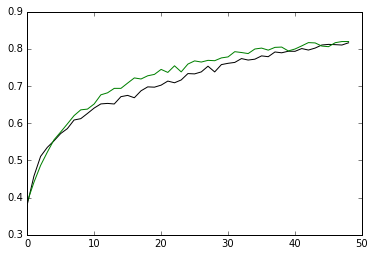

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure()
# plt.plot(fb_val_acc_2_2, 'y')
# plt.plot(val_acc_2_2)
# plt.plot(val_acc_3_2, 'r')
# plt.plot(val_acc_2_3, 'g')
plt.plot(val_acc_3_3, 'k')
plt.plot(fb_val_acc_3_3, 'g')
# plt.plot(val_acc_3_4, 'c')
# plt.legend(['2 digits 2 ops', '3 digits 2 ops', '2 digits 3 ops', '3 digits 3 ops', '3 digits 4 ops'])

In [70]:
# Analysis of the learned encoder-decoder model

In [47]:
def mapper_f(X):
    # The [0] is to disable the training phase flag
    return mapper_f_([0] + [X])

def decoder_f(X):
    # The [0] is to disable the training phase flag
    return decoder_f_([0] + [X])
    

In [51]:
X_str = '11+11'
X = ctable.encode(X_str).reshape([1,5,12])
W, b = mapper.get_weights()
mapper_f(X)

[array([[[ -3.74993334,  -4.55328167,   0.01977423,   2.09654183,
            8.09789021,   4.68821497,   0.53697948,  -2.49086057,
           -3.2629156 ,  -4.50310532,  -1.57462059,  -0.20300366],
         [  1.56371894,  -6.47915125,   2.77159742,   6.27940721,
            9.18885044,   5.69487154,   1.3087312 ,  -2.63035432,
           -5.86969941,  -8.94112606,  -5.5314091 ,  -2.08335258],
         [ 13.67693126,  -3.73067182,   3.47792178,   5.16250705,
            8.07482081,   5.58948533,   1.14923727,  -1.88810326,
           -5.8391964 , -11.13807178,  -7.34046943,  -4.46157491]]])]

In [56]:
W[:,4]

array([-0.2456825 ,  0.16755757, -0.33701023, -0.51029809,  0.16704274,
        0.05060765, -0.4070679 , -0.27207215,  0.52950274, -0.47397486,
        0.17837239,  0.33134702, -0.24562971,  0.38917464,  0.06534097,
        0.3276419 , -0.21885674,  0.19534894,  0.26957407,  0.29943314,
        0.37769917, -0.16922046, -0.74944632,  0.13137945, -0.19629851,
       -0.01970104, -0.32160261,  0.08821762, -0.42511377,  0.51874013,
       -0.25834064,  0.18680713,  0.01018852, -0.06316201, -0.30473278,
        0.14282574, -0.05318288, -0.28956504,  0.07492588, -0.43659161,
        0.29996792,  0.04896545,  0.39091503,  0.05661917,  0.29111949,
       -0.4287446 , -0.25520077,  0.04762556, -0.05536564, -0.18708102,
       -0.05494532,  0.0093084 , -0.60343276,  0.0504667 ,  0.20767928,
        0.09604852,  0.24338928,  0.20850986,  0.08948059, -0.47612048,
        0.3113876 , -0.59570096,  0.22423629, -0.03163029,  0.25622493,
       -0.102194  ,  0.23280459,  0.29661305,  0.24910164, -0.14

In [64]:
H = decoder_f(X)
H[0].shape
H[0][0,2,:]

array([-0.97151031,  0.4532975 ,  0.55860064,  0.98525621,  0.95864268,
        0.18161577,  0.30326506, -0.98672365, -0.09086472,  0.88432842,
        0.76149831,  0.15868701, -0.35169137,  0.95255127,  0.80659519,
        0.76158567, -0.27088097,  0.98593224, -0.95393045,  0.96984609,
        0.98384946,  0.        , -0.5519319 ,  0.31803958, -0.97685555,
        0.49189291, -0.72680228,  0.73063137, -0.99480244,  0.99133871,
        0.75889144,  0.44631388, -0.59378038,  0.52844653,  0.40256829,
        0.5923108 ,  0.01480254,  0.89134252,  0.73491992, -0.75775531,
        0.99473534,  0.81063833, -0.99137843,  0.77970595, -0.14046007,
        0.32391504,  0.9108693 ,  0.55375808,  0.74046082,  0.65002752,
        0.99276884,  0.76045368, -0.96758929,  0.2422195 ,  0.96872671,
       -0.75988805,  0.11701007,  0.76366146,  0.75390171,  0.76917183,
        0.76082376,  0.74983536,  0.97375558, -0.74690409, -0.24497831,
        0.89535008,  0.48070586, -0.16770076, -0.59012355, -0.  